The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


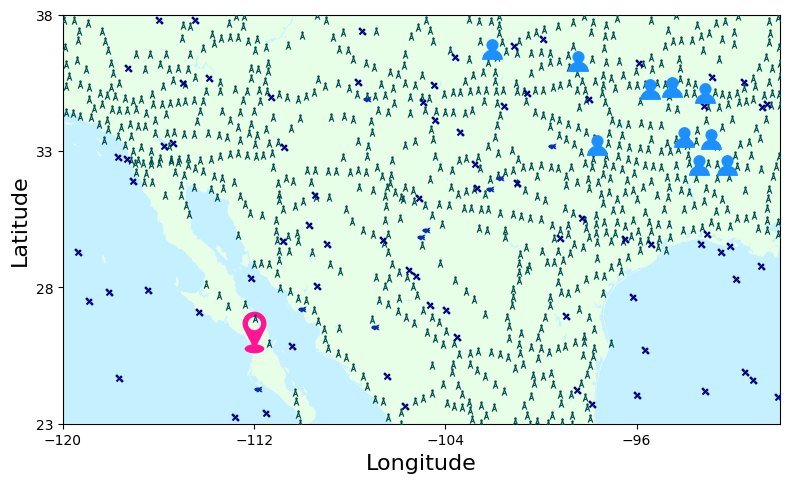

In [176]:
%load_ext autoreload
%autoreload 2

from ssir.pathfinder import astar, genetic, bruteforce, montecarlo, greedy
import ssir.environment as env
from ssir import basestations as bs
import datetime as dt
import random

latitude_range = [23, 38]
longitude_range = [-120, -90]
random_seed = 2
random.seed(random_seed)

ground_coords_1 = env.load_ground_positions("./map/ground_positions_mexico.csv", latitude_range, longitude_range, duplicate_tol=0.3)
ground_coords_2 = env.load_ground_positions("./map/ground_positions_USA.csv", latitude_range, longitude_range, duplicate_tol=0.3)
ground_coords = ground_coords_1 + ground_coords_2
tmp_coords = env.load_maritime_positions("./map/maritime_positions.csv")
maritime_coords = random.sample(tmp_coords, 50)
haps_coords = env.load_haps_positions("./map/haps_positions.csv", dt.datetime(2020, 7, 29, 0, 0)) # Mexico
leo_coords = env.load_leo_positions("./map/starlink_positions.csv", latitude_range, longitude_range)
area_size = (latitude_range[1] - latitude_range[0]) * (longitude_range[1] - longitude_range[0])
# Randomly generate users within the specified range
user_coords = []
for _ in range(10):
    lat = random.uniform(30, 37)
    lon = random.uniform(-104, -92)
    user_coords.append((lat, lon))
config = {
    "num_maritime_basestations": int(area_size / 4),
    "num_ground_basestations": int(area_size / 4),
    "num_haps_basestations": int(area_size / 50),
    "num_leo_basestations": 1,
    "num_users": int(area_size / 15),
    "random_seed": random_seed,
    "longitude_range": longitude_range,
    "latitude_range": latitude_range,
}
bs.environmental_variables.SPSC_probability = 0.9999
dm = env.DataManager(**config, 
                     source_coords=[(26, -112)],
                     ground_coords=ground_coords, 
                     maritime_coords=maritime_coords,
                     haps_coords=haps_coords,
                     leo_coords=leo_coords,
                     user_coords=user_coords,
                     )
pm = env.PlotManager()
graph = dm.generate_master_graph()
pm.plot(dm, legend=False)

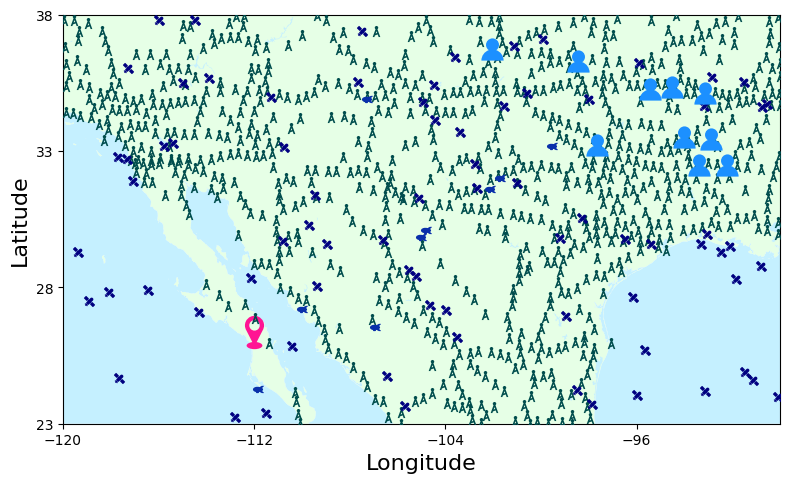

In [214]:
pm.plot(dm, legend=False, save_path="eps/0_map.eps")

Montecarlo throughput: 104830.26066105478


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


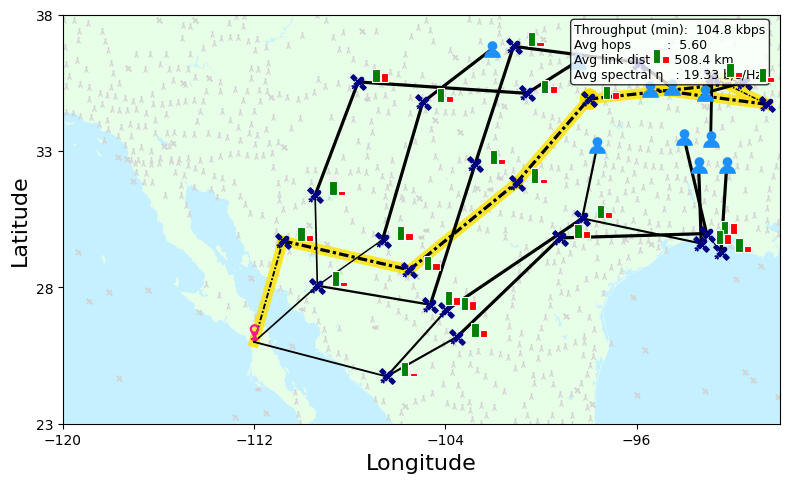

In [179]:
graph_montecarlo = montecarlo.get_solution_graph(graph, 500, 5, 5, verbose=False)
print(f"Montecarlo throughput: {graph_montecarlo.compute_network_throughput()}")
pm.plot(dm, graph_montecarlo, legend=False, save_path="./eps/1_normal.eps", plot=False)

Montecarlo throughput: 5786.012295080006


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


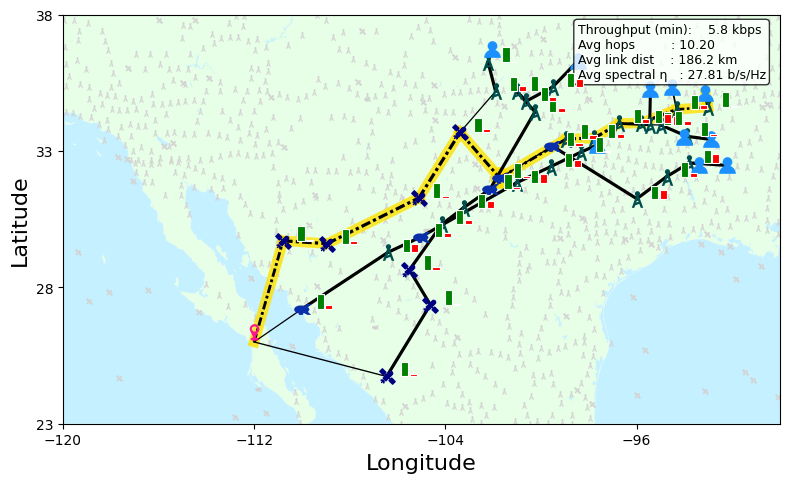

In [ ]:
from dataclasses import replace
# Increase eve density of the LEO basestations
graph_leo = graph.copy()
graph_leo.reset()

for node in graph_leo.basestations:
    if node.basestation_type.name == "LEO":
        node.config = replace(node.basestation_type.config, eavesdropper_density=4e-4)
graph_leo.connect_reachable_nodes()

graph_montecarlo = montecarlo.get_solution_graph(graph_leo, 100, 5, 5, verbose=False)
print(f"Montecarlo throughput: {graph_montecarlo.compute_network_throughput()}")
pm.plot(dm, graph_montecarlo, legend=False, save_path="./eps/2_eve_density_up.eps", plot=False)

Montecarlo throughput: 99748.5041945159


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


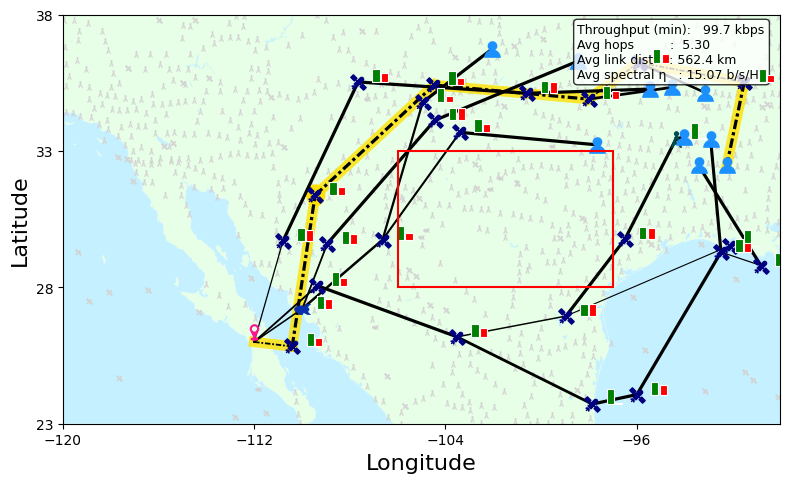

In [210]:
from dataclasses import replace
# Increase eve density of the LEO basestations
graph_leo = graph.copy()
graph_leo.reset()

bbox = [-106, -97, 28, 33]

for node in graph_leo.basestations:
    if node.basestation_type.name == "LEO" and (
        bbox[0] < node._position[0] < bbox[1] and bbox[2] < node._position[1] < bbox[3]
    ):
        node.config = replace(node.basestation_type.config, eavesdropper_density=1)
graph_leo.connect_reachable_nodes()

graph_montecarlo = montecarlo.get_solution_graph(graph_leo, 100, 5, 5, verbose=False)
print(f"Montecarlo throughput: {graph_montecarlo.compute_network_throughput()}")
pm.plot(dm, graph_montecarlo, legend=False, save_path="./eps/4_banned_area.eps", plot=False, draw_bbox=bbox)

0.0001 BaseStationType.LEO


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


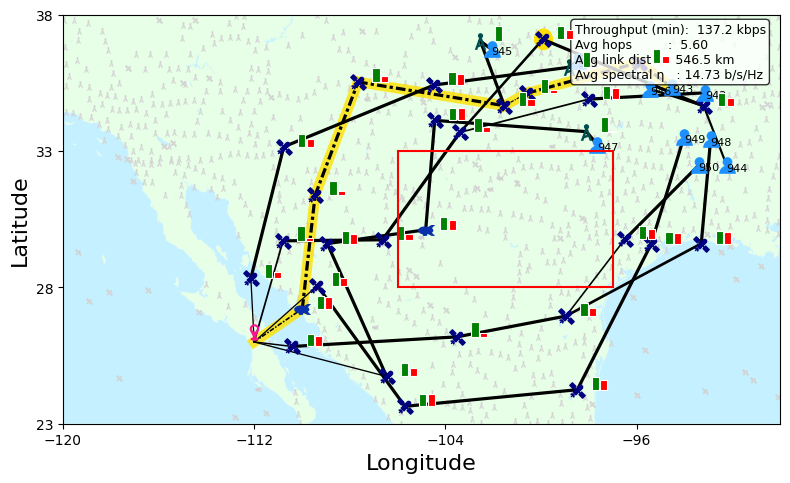

In [209]:
g=graph_montecarlo
uid_list = [u.get_id() for u in g.users]
u = g.nodes[947].get_parent()[0].get_parent()[0]
print(u.config.eavesdropper_density, u.basestation_type)

pm.plot(dm, graph_montecarlo, legend=False, save_path="./eps/4_banned_area.eps", plot=False, draw_bbox=bbox, verbose_id=uid_list)